In [46]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from StatzFunctions import *

In [47]:
from matplotlib.font_manager import FontProperties

# Specify your font
regular = FontProperties(fname="C:\\Users\\George\\Documents\\Football Analytics\\Kanit-Regular.ttf")  # Update the path to where the font is installed on your system
light = FontProperties(fname="C:\\Users\\George\\Documents\\Football Analytics\\Kanit-Light.ttf")  # Update the path to where the font is installed on your system
bold = FontProperties(fname="C:\\Users\\George\\Documents\\Football Analytics\\Kanit-Bold.ttf")  # Update the path to where the font is installed on your system

In [48]:
# CHANGE THESE
top_right_comment = "Dominant in the Air,\nand Progressive in Possession"
top_left_comment = "Dominant in the Air,\nbut Safe in Possession"
bottom_right_comment = "Vulnerable in the Air,\nbut Progressive in Possession"
bottom_left_comment = "Vulnerable in the Air,\nand Safe in Possession"

In [49]:
stat = 'Goals' # x axis
fbref_stat_name = 'Gls'
stat_outcome = 'Good' # 'Good', 'Bad'
fbref_stat_table_name = 'stats'
stat2 = 'xG' # y axis
fbref_stat2_name = 'xG'
stat2_outcome = 'Good' # 'Good', 'Bad'
fbref_stat2_table_name = 'stats'
stat2_perc = False
pos = ['right-wing'] # ['midfielder','right-wing', 'defensive-midfied', 'right-back', 'centre-forward','attacking-midfied', 'central-midfied', 'left-wing', 'left-back','centre-back', 'left-midfield', 'right-midfield','secondary_striker', 'goalkeeper']
league_name = 'Championship' # 'Premier League', 'La Liga', 'Serie A', 'Bundesliga', 'Ligue 1', 'Championship
league_id = 9 #                      8,             564,       384,         82,          301,         9
season_id = 23672 #                23614,         23621,     23746,       23744,       23643,      23672
fbref_league_id = 10
matches = 15  # Min number of matches played to be included in the viz

In [50]:
league_name_dash = league_name.replace(' ', '-')
year_range = '2024-2025'
dot_type = 'badge'

In [51]:
players = pd.read_csv(r"C:\Users\George\Documents\Statz.ai\Data\players.csv")
players['position_detailed'].fillna(players['position'], inplace=True)
player_stats = pd.read_csv(r"C:\Users\George\Documents\Statz.ai\Data\fixture_player_stats.csv")
stats_types = pd.read_csv(r"C:\Users\George\Documents\Statz.ai\Data\stats_types.csv")
teams = pd.read_csv(r"C:\Users\George\Documents\Statz.ai\Data\teams.csv")
fixtures = pd.read_csv(r"C:\Users\George\Documents\Statz.ai\Data\fixtures.csv")
fixtures = fixtures[fixtures['competition_id'] == league_id]
fixtures = fixtures[fixtures['season_id'] == season_id]
fixtures.reset_index(drop=True, inplace=True)
player_stats = player_stats[player_stats['fixture_id'].isin(fixtures['id'])]

In [58]:
url = f'https://fbref.com/en/comps/{fbref_league_id}/{fbref_stat_table_name}/{league_name_dash}-Stats'
response = requests.get(url).text.replace('<!--', '').replace('-->', '')
df = pd.read_html(response, header=1)[2]

In [ ]:
if fbref_stat_name != fbref_stat2_table_name:
    url2 = f'https://fbref.com/en/comps/{fbref_league_id}/{fbref_stat2_table_name}/{league_name_dash}-Stats'
    response2 = requests.get(url2).text.replace('<!--', '').replace('-->', '')
    df2 = pd.read_html(response2, header=1)[2]
    df2 = df2[['Player',f'{fbref_stat2_name}']]
    df = pd.merge(df, df2, on='Player', how='left')

In [60]:
df.rename(columns={f'{fbref_stat_name}': stat, f'{fbref_stat2_name}': stat2}, inplace=True)

In [61]:
df = df[df['Player'] != 'Player']

In [62]:
df['90s'] = df['90s'].astype(float)
df[stat] = df[stat].astype(float)
df[stat2] = df[stat2].astype(float)
df[stat] = df[stat] / df['90s']
df[stat2] = df[stat2] / df['90s']

In [63]:
df = df[['Pos','Player','90s', stat, stat2]]

In [64]:
df = df[df['90s'] > matches].reset_index(drop=True)

In [65]:
df = df.loc[df.groupby('Player')['90s'].idxmax()].reset_index(drop=True)

In [66]:
def get_team_badge(team_name, teams = teams):
    team = teams[teams['name'] == team_name]
    return team['badge'].values[0]

In [67]:
def get_all_players_stat(players, player_stats, stats_types, stat_name, perc=False, teams = teams):
    stat_id = stats_types[stats_types['name'] == stat_name]['id'].values[0]
    player_mins = player_stats[player_stats['stats_type_id'] == 119]
    player_mins = player_mins.groupby('player_id').sum().reset_index()
    player_mins = player_mins[['player_id', 'value']]
    player_mins.rename(columns={'value': 'Mins'}, inplace=True)
    player_stat = player_stats[player_stats['stats_type_id'] == stat_id]
    if perc:
        player_stat = player_stat.groupby('player_id')['value'].mean().reset_index()
    else:
        player_stat = player_stat.groupby('player_id').sum().reset_index()
    player_stat = player_stat.sort_values(by='value', ascending=False)
    player_stat = player_stat.merge(player_mins, on='player_id')
    player_stat = player_stat.merge(players, left_on='player_id', right_on='id')
    player_stat.rename(columns={'value': stat_name,'display_name':'Player','position_detailed':'Position'}, inplace=True)
    teams = []
    for i in range(len(player_stat)):
        try: 
            teams.append(get_team(player_stat['current_team_id'][i]))
        except:
            player_stat.drop(i, inplace=True)
    player_stat.reset_index(drop=True, inplace=True)
    player_stat['Team'] = teams
    player_stat['Team Badge'] = player_stat['Team'].apply(get_team_badge)
    player_stat = player_stat[['Player', 'Position', 'Mins', stat_name, 'Team', 'Team Badge']]
    player_stat['Mins'] = player_stat['Mins'].astype(int)
    if perc:
        return player_stat
    else:
        player_stat[stat_name] = player_stat[stat_name].astype(int)
        return player_stat.reset_index(drop=True)

In [68]:
badge_df = get_all_players_stat(players, player_stats, stats_types, 'Duels Won')

In [69]:
badge_df = badge_df[['Player','Position','Team','Team Badge']]

In [70]:
final_df = pd.merge(df, badge_df, on='Player', how='left')

In [71]:
final_df.dropna(inplace=True)
final_df = final_df[final_df['Position'].isin(pos)]
final_df.reset_index(drop=True, inplace=True)

In [72]:
df = final_df.copy()

In [73]:
player_short = []
for player in df['Player']:
    if 'Van ' in player:
        player_short.append(player.split()[-3] + ' ' + player.split()[-2] + ' ' + player.split()[-1])
    elif ' van ' in player:
        player_short.append(player.split()[-3] + ' ' + player.split()[-2] + ' ' + player.split()[-1])
    elif len(player.split()) > 2:
        player_short.append(player.split()[-2] + ' ' + player.split()[-1])
    else:
        player_short.append(player.split()[-1])
df['Player'] = player_short

In [74]:
import urllib.request
def convert_images(df):
    team_badge_path = []
    for i in range(len(df)):
        if '/' in df.iloc[i]['Team']:
            team = df.iloc[i]['Team'].split('/ ')[0] + df.iloc[i]['Team'].split('/ ')[1]
            urllib.request.urlretrieve(df.iloc[i]['Team Badge'], rf"C:\Users\George\Documents\Statz.ai\Images\Teams\{team}.png")
            team_badge_path.append(rf"C:\Users\George\Documents\Statz.ai\Images\Teams\{team}.png")
        else:
            urllib.request.urlretrieve(df.iloc[i]['Team Badge'], rf"C:\Users\George\Documents\Statz.ai\Images\Teams\{df.iloc[i]['Team']}.png")
            team_badge_path.append(rf"C:\Users\George\Documents\Statz.ai\Images\Teams\{df.iloc[i]['Team']}.png")
    df['Team Badge'] = team_badge_path
    return df

In [75]:
if dot_type == 'badge':
    df_names = convert_images(df)

In [76]:
if stat_outcome == 'Good':
    buffer = df[stat].max()
else:
    buffer = -df[stat].max()
if stat2_outcome == 'Good':
    buffer2 = df[stat2].max()
else:
    buffer2 = -df[stat2].max()

In [77]:
padding1 = ((df_names[stat].max()-df_names[stat].min()) / 80)
padding2 = ((df_names[stat2].max()-df_names[stat2].min()) / 50)

In [78]:
todays_date = pd.to_datetime('today').strftime('%d %B %Y')

In [82]:
df.rename(columns={stat: stat + ' per 90', stat2: stat2 + ' per 90'}, inplace=True)

In [92]:
def plot_scatter(df_names, stat, stat2, stat_outcome, stat2_outcome, league_name, matches, position, top_left_comment, top_right_comment, bottom_left_comment, bottom_right_comment):
    from adjustText import adjust_text
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    from matplotlib.font_manager import FontProperties

    # Create a figure and axis
    plt.figure(figsize=(12, 8), dpi=200, facecolor='#F5F6F1')

    # Scatter plot
    plt.scatter(df_names[stat + ' per 90'], df_names[stat2 + ' per 90'], color='#F5F6F1', s=0, alpha=1, edgecolor='#F5F6F1', linewidth=0.5)
    
    # Add player names as text labels
    texts = [plt.text(x, y, text, color='black', fontsize=8, fontproperties = regular, ha = 'center', va = 'bottom') for x, y, text in zip(df_names[stat + ' per 90'] - padding1, df_names[stat2 + ' per 90'] + padding2, df_names['Player'])]
    adjust_text(texts, expand = (1.3,1.3))

    # Add team badges
    for i, team in df_names.iterrows():
        badge = plt.imread(team['Team Badge'])
        if stat_outcome == 'Bad' and stat2_outcome == 'Bad':
            plt.imshow(np.fliplr(np.flipud(badge)), extent=(team[stat + ' per 90']-padding1, team[stat + ' per 90']+padding1, team[stat2 + ' per 90']-padding2, team[stat2 + ' per 90']+padding2), aspect='auto', alpha=0.85)
        elif stat_outcome == 'Bad':
            plt.imshow(np.fliplr(badge), extent=(team[stat + ' per 90']-padding1, team[stat + ' per 90']+padding1, team[stat2 + ' per 90']-padding2, team[stat2 + ' per 90']+padding2), aspect='auto', alpha=0.85)
        elif stat2_outcome == 'Bad':
            plt.imshow(np.flipud(badge), extent=(team[stat + ' per 90']-padding1, team[stat + ' per 90']+padding1, team[stat2 + ' per 90']-padding2, team[stat2 + ' per 90']+padding2), aspect='auto', alpha=0.85)
        else:
            plt.imshow(badge, extent=(team[stat + ' per 90']-padding1, team[stat + ' per 90']+padding1, team[stat2 + ' per 90']-padding2, team[stat2 + ' per 90']+padding2), aspect='auto', alpha=0.85)
                            
    # Add Axis Labels
    plt.ylabel(stat2 + ' per 90', fontproperties = regular, size = 14)  
    plt.xlabel(stat + ' per 90', fontproperties = regular, size = 14)  

    if stat_outcome == 'Good':
        plt.xlim(df_names[stat + ' per 90'].min()-(df_names[stat + ' per 90'].max())*0.05, df_names[stat + ' per 90'].max()+(df_names[stat + ' per 90'].max())*0.05)
    else:
        plt.xlim(df_names[stat + ' per 90'].max()+(df_names[stat + ' per 90'].max())*0.05, df_names[stat + ' per 90'].min()-(df_names[stat + ' per 90'].max())*0.05)
    if stat2_outcome == 'Good':
        plt.ylim(df_names[stat2 + ' per 90'].min()-(df_names[stat2 + ' per 90'].max())*0.1, df_names[stat2 + ' per 90'].max()+(df_names[stat2 + ' per 90'].max())*0.1)
    else:
        plt.ylim(df_names[stat2 + ' per 90'].max()+(df_names[stat2 + ' per 90'].max())*0.05, df_names[stat2 + ' per 90'].min()-(df_names[stat2 + ' per 90'].max())*0.05)

    # Draw a line from the y-axis at the average value
    plt.axvline(df_names[stat + ' per 90'].mean(), color='grey', linestyle='--', alpha=0.5)
    plt.axhline(df_names[stat2 + ' per 90'].mean(), color='grey', linestyle='--', alpha=0.5)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_color('grey')
    plt.gca().spines['bottom'].set_color('grey')
    plt.gca().spines['left'].set_alpha(0.5)
    plt.gca().spines['bottom'].set_alpha(0.5)

    xlim = plt.xlim()
    ylim = plt.ylim()

    plt.text(xlim[0] + (buffer)*0.005, df_names[stat2 + ' per 90'].mean() + (buffer2)*0.01, 'Average ' + stat2, color='grey', fontsize=8, ha='left', va='center', fontproperties = light)
    plt.text(df_names[stat + ' per 90'].mean() + (buffer)*0.01, ylim[0] + (buffer2)*0.02, 'Average ' + stat, color='grey', fontsize=8, ha='left', va='top', fontproperties = light)

    # Top Left
    plt.text(xlim[0] + buffer*0.025, ylim[1], top_left_comment, 
            bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='none'),
            ha='left', va='top', fontsize=10, wrap=True, fontproperties = regular)
    # Top Right
    plt.text(xlim[1] - buffer*0.025, ylim[1], top_right_comment, 
            bbox=dict(facecolor='lightgreen', alpha=0.5, edgecolor='none'),
            ha='right', va='top', fontsize=10, wrap=True, fontproperties = regular)
    # Bottom Left
    plt.text(xlim[0] + buffer*0.025, ylim[0] + buffer2*0.001, bottom_left_comment, 
            bbox=dict(facecolor='lightcoral', alpha=0.5, edgecolor='none'),
            ha='left', va='bottom', fontsize=10, wrap=True, fontproperties = regular)
    # Bottom Right
    plt.text(xlim[1] - buffer*0.025, ylim[0] + buffer2*0.001, bottom_right_comment, 
            bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='none'),
            ha='right', va='bottom', fontsize=10, wrap=True, fontproperties = regular)

    plt.text(0,1.12, f"{league_name} | {stat} & {stat2}", ha = 'left',fontsize=22, transform=plt.gca().transAxes, fontproperties=bold)
    plt.text(0,1.05, f"Updated: {todays_date} | {league_name} 24-25 | Players with > {(round(matches,1))} 90s\nData: @Statz.ai | Graphic: @Statz.ai", ha = 'left',fontsize=9, transform=plt.gca().transAxes, fontproperties=light)
    #plt.text(0.8,1.05, f"Through match week {gameweek}", ha = 'right',fontsize=18, transform=plt.gca().transAxes, fontproperties=regular, color='grey', alpha=0.5)

    # Set the ticks color to white
    plt.xticks(fontproperties = regular)
    plt.yticks(fontproperties = regular)

    # Set the plot background color to #141514
    plt.gca().set_facecolor('#F5F6F1')
    # Add text box in each quadrant

    statz_logo = plt.imread(r"C:\Users\George\Documents\Statz.ai\Images\Logos and Backgrounds\Statz Long Logo Purple.png")
    imagebox = OffsetImage(statz_logo, zoom=0.15)
    ab = AnnotationBbox(imagebox, (0.9, 1.13), frameon=False, xycoords='axes fraction', boxcoords="axes fraction")
    plt.gca().add_artist(ab)

    plt.savefig(
        f"C:/Users/George/Documents/Statz.ai/Visuals/Player Graphs/{league_name}/{stat} v {stat2}.png",
        dpi=600,
        bbox_inches="tight"
    )

    plt.show()

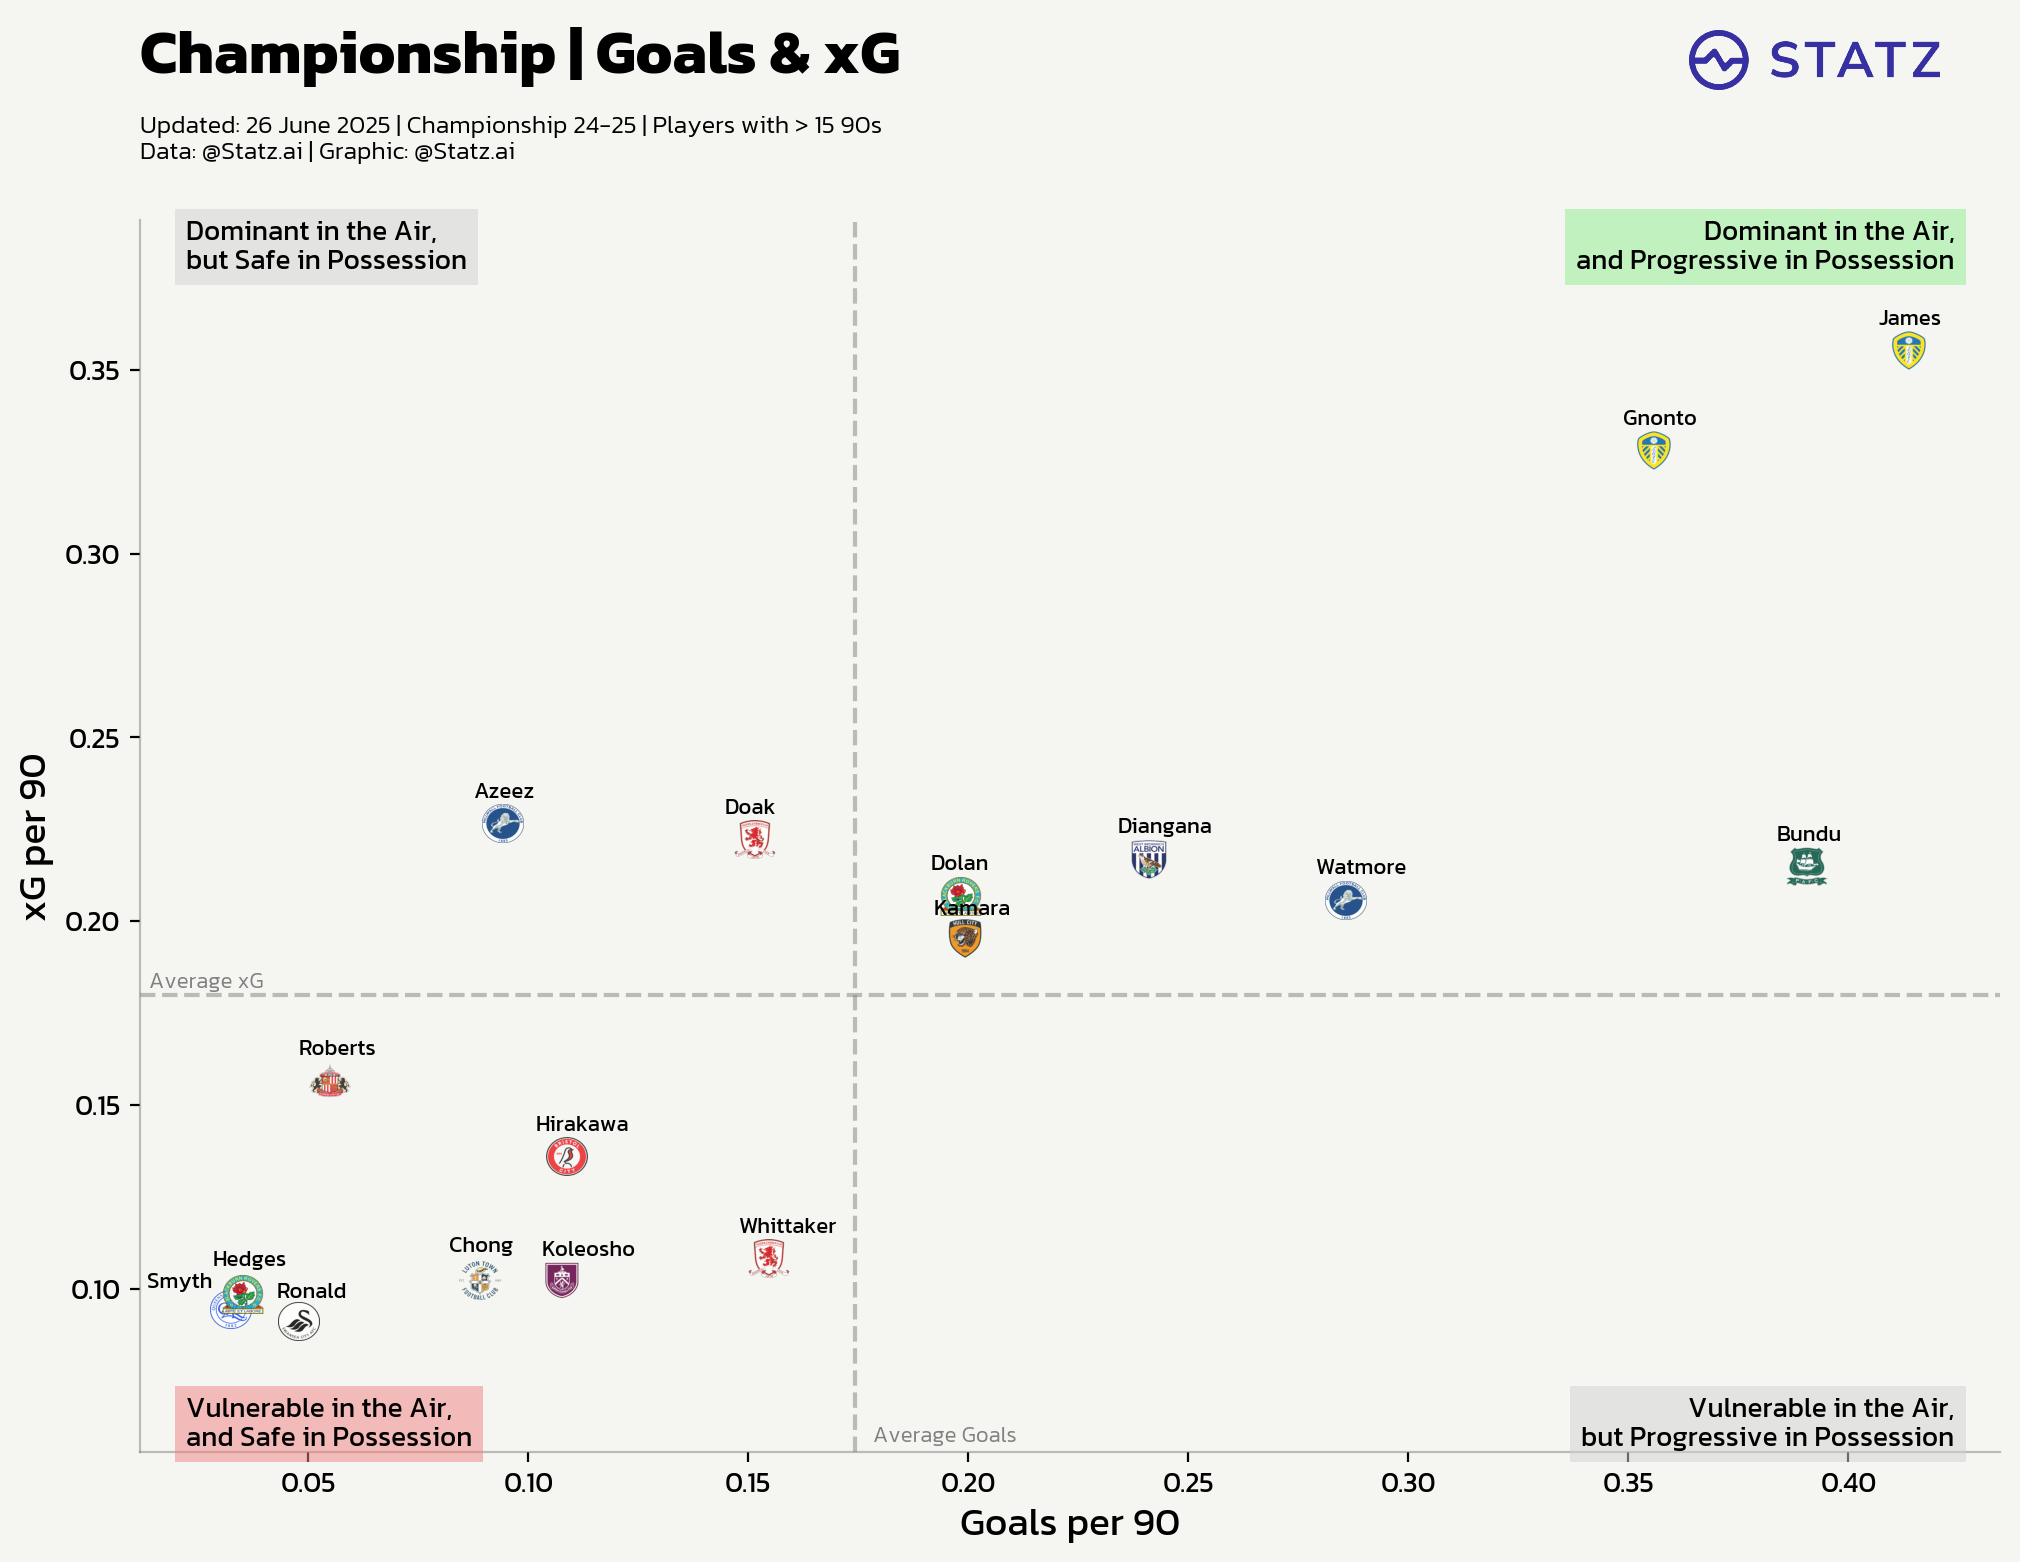

In [93]:
plot_scatter(df_names, stat, stat2, stat_outcome, stat2_outcome, league_name, matches, pos, top_left_comment, top_right_comment, bottom_left_comment, bottom_right_comment)